# Ravelry Pattern Recommender
> Recommend Wool knitted desings (artifacts) to users

- toc: true
- badges: true
- comments: true
- categories: [SVD, Surprise, API, Art&Culture]
- image:

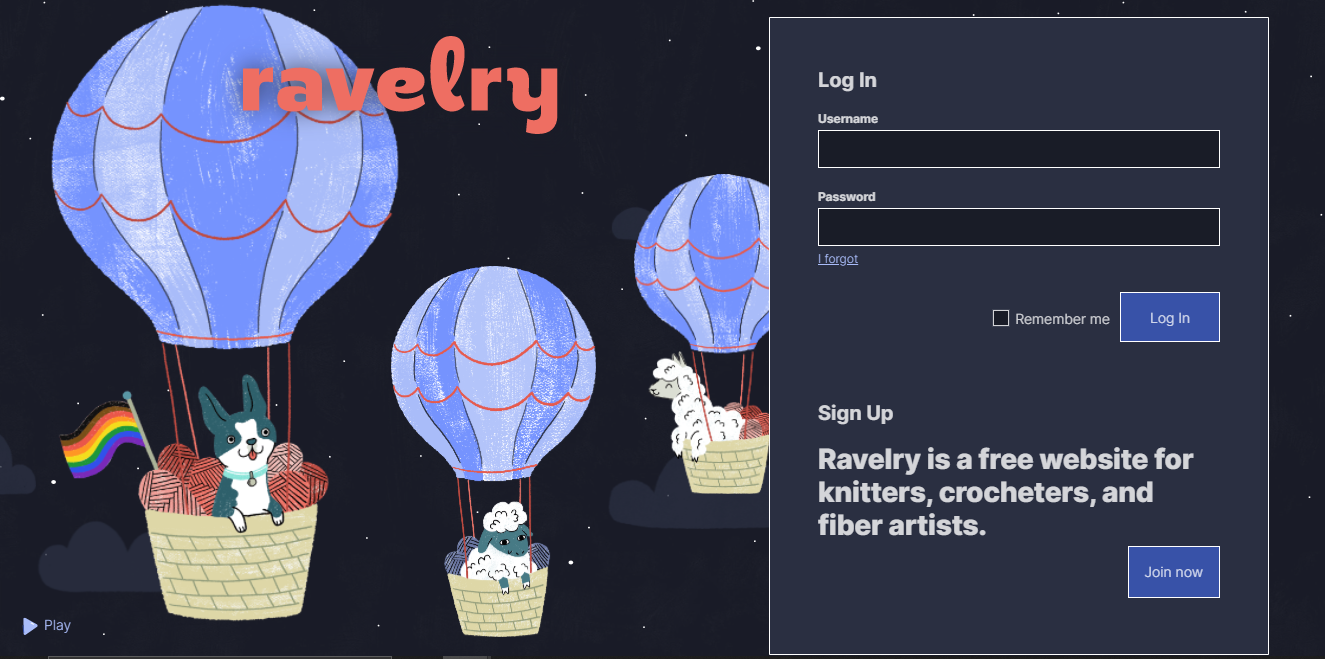

[Ravelry](https://www.ravelry.com/about) describes itself as a place for knitters, crocheters, designers, spinners, weavers and dyers to keep track of their yarn, tools, project and pattern information, and look to others for ideas and inspiration.

## Setup

In [ ]:
!pip install -q surprise

In [16]:
import pandas as pd
import numpy as np
import datetime as dt

import surprise
from surprise.prediction_algorithms import *
from surprise import Reader, Dataset
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [53]:
!pip install -q watermark
%reload_ext watermark
%watermark -m -iv

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy   : 1.19.5
IPython : 5.5.0
pandas  : 1.1.5
surprise: 0.1
sys     : 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]



In [ ]:
# Poetry is a tool for dependency management and packaging in Python. 
# It allows you to declare the libraries your project depends on and it will manage (install/update) them for you.
# https://python-poetry.org/docs/basic-usage/
# !curl -sSL https://raw.githubusercontent.com/python-poetry/poetry/master/install-poetry.py | python -
# !/root/.local/bin/poetry --version
# !/root/.local/bin/poetry new poetry-demo
# %cd poetry-demo
# !/root/.local/bin/poetry install
# !/root/.local/bin/poetry add numpy

## What are patterns?

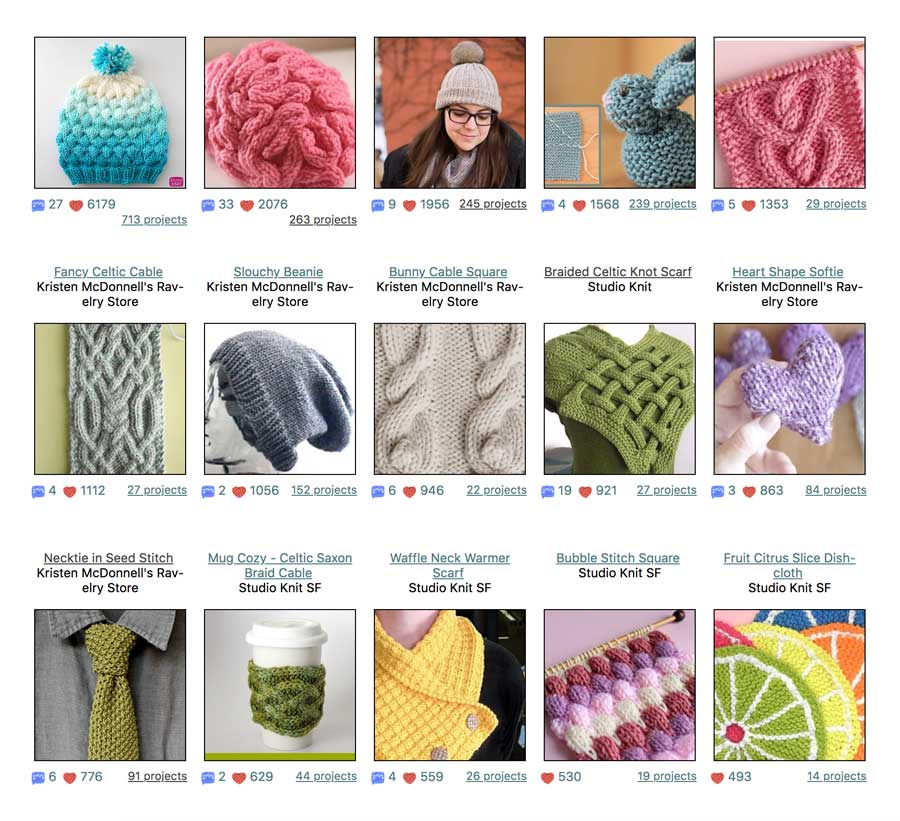

> youtube: https://youtu.be/ybEClAPFF8M

## Data

### Data Fetching from API (optional)

In [ ]:
# import pandas as pd
# import requests
# import json
# import random
# import numpy

# with open('creds.json') as f:
#     creds = json.load(f)

# users = []

# for i in random.sample(range(1, 12000000), 50000):
#     try:
#         url ='https://api.ravelry.com/people/' + str(i) +'.json'
#         response = requests.get(url, auth=(creds['id'], creds['key']))
#         users.append(response.json()['user']['username'])
#     except ValueError: 
#         pass
#     if len(set(users)) >10000:
#         break

# parsed_data = []

# for i, user in enumerate(users[9935:]): 
    
#     url ='https://api.ravelry.com/projects/' + user + '/list.json?sort=completed_'
#     response = requests.get(url, auth=(creds['id'], creds['key']))
    
#     try:
#         for project in response.json()['projects']:
#             if project['craft_name'] == 'Knitting': 
#                 if project['pattern_id'] != None:
#                     pattern_url ='https://api.ravelry.com/patterns.json?ids=' + str(int(project['pattern_id']))
#                     pattern_response = requests.get(pattern_url, auth=(creds['id'], creds['key']))
#                     project_tuple = (user, project['completed'], project['rating'], project['status_name'], 
#                                      project['pattern_id'],
#                                      pattern_response.json()['patterns'][str(int(project['pattern_id']))]['rating_average'],
#                                      pattern_response.json()['patterns'][str(int(project['pattern_id']))]['rating_count'])
#                     parsed_data.append(project_tuple)   
            
#     except ValueError:
#         pass

#     print(i, len(parsed_data))

# df = pd.DataFrame(parsed_data, columns= ['user', 'completed', 'rating', 'status', 'pattern_id', 'average_rating', 'rating_count'])

# finished_projects = df[df['status'] == 'Finished']
# finished_projects.to_csv('ravelry_interactions.csv', index=False)

### Direct loading from drive

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/recohut/reco-data/ravelry/ravelry/v1/ravelry_interactions.csv')
df

,user,completed,rating,status,pattern_id,average_rating,rating_count
0,hannahcf,2018/11/25,4.0,Finished,17468,4.520376,1276.0
1,hannahcf,2018/05/05,4.0,Finished,629964,4.285714,7.0
2,hannahcf,2018/03/13,4.0,Finished,287992,4.554957,928.0
3,hannahcf,2018/01/31,4.0,Finished,475167,4.500000,4.0
4,hannahcf,2018/01/05,4.0,Finished,544863,4.662651,332.0
...,...,...,...,...,...,...,...
11117,creativratte,2015/08/14,4.0,Finished,223414,4.611111,18.0
11118,creativratte,2015/06/21,4.0,Finished,467793,4.667697,647.0
11119,creativratte,2015/05/10,4.0,Finished,211562,4.668034,9263.0
11120,creativratte,2015/02/07,4.0,Finished,250525,4.629565,575.0


## Preprocessing

In [9]:
df_drop_nans = df[['user', 'pattern_id', 'rating']].dropna(subset = ['rating'])
df_drop_nans

,user,pattern_id,rating
0,hannahcf,17468,4.0
1,hannahcf,629964,4.0
2,hannahcf,287992,4.0
3,hannahcf,475167,4.0
4,hannahcf,544863,4.0
...,...,...,...
11117,creativratte,223414,4.0
11118,creativratte,467793,4.0
11119,creativratte,211562,4.0
11120,creativratte,250525,4.0


In [12]:
df_drop_nans.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user,8794,383,ciri,348,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pattern_id,8794,NaN,NaN,NaN,352854,295926,16,106818,267731,564484,1.1567e+06
rating,8794,NaN,NaN,NaN,3.65783,0.569459,0,3,4,4,4


In [14]:
df_replace_nans = df[['user', 'pattern_id', 'rating', 'average_rating']]
rating_replace_nans = df_replace_nans['rating'].fillna(df_replace_nans['average_rating'])
df_replace_nans['rating'] = rating_replace_nans
df_replace_nans.drop(columns = 'average_rating', inplace = True)
df_replace_nans

,user,pattern_id,rating
0,hannahcf,17468,4.0
1,hannahcf,629964,4.0
2,hannahcf,287992,4.0
3,hannahcf,475167,4.0
4,hannahcf,544863,4.0
...,...,...,...
11117,creativratte,223414,4.0
11118,creativratte,467793,4.0
11119,creativratte,211562,4.0
11120,creativratte,250525,4.0


## Surprise Dataset

In [17]:
reader = Reader()
data_replace = Dataset.load_from_df(df_replace_nans, reader)
data_drop = Dataset.load_from_df(df_drop_nans, reader)

In [18]:
drop_trainset, drop_testset = train_test_split(data_drop, test_size=0.25)
replace_trainset, replace_testset = train_test_split(data_replace, test_size=0.25)

In [27]:
drop_trainset.global_mean

3.6579226686884003

## SVD model

In [20]:
algo = SVD(n_factors = 50, n_epochs = 45, lr_all = 0.004, reg_all = 0.2)
algo.fit(drop_trainset)

In [21]:
predictions = algo.test(drop_testset)

In [22]:
accuracy.rmse(predictions)

RMSE: 0.4870


0.4869683491545024

## Hyperparameter search

In [ ]:
param_grid = {'n_factors':[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              'n_epochs': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 
              'lr_all': [0.002, 0.003, 0.004, 0.005],
              'reg_all': [0.2, 0.3, 0.4, 0.5, 0.6]}

gs_model = GridSearchCV(SVD,
                        param_grid=param_grid,
                        n_jobs = -1,
                        joblib_verbose=5)

gs_model.fit(data_drop)

gs_model.best_params

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 2174 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 3038 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 3524 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | ela

## Inference (rating prediction)

In [48]:
algo = SVD(**gs_model.best_params['rmse'])
algo.fit(drop_trainset)
predictions = algo.test(drop_testset)
accuracy.rmse(predictions)

RMSE: 0.4866


0.4866481194826417

In [49]:
predictions_df = pd.DataFrame({"user": [prediction.uid for prediction in predictions],
                   "item": [prediction.iid for prediction in predictions],
                   "actual": [prediction.r_ui for prediction in predictions],
                   "estimated" :[prediction.est for prediction in predictions]})

In [50]:
predictions_df[predictions_df['user'] == 'Ona'].describe()

,item,actual,estimated
count,2.000000,2.000000,2.000000
mean,269733.500000,3.500000,3.798873
std,124075.319788,0.707107,0.028703
min,181999.000000,3.000000,3.778577
25%,225866.250000,3.250000,3.788725
50%,269733.500000,3.500000,3.798873
75%,313600.750000,3.750000,3.809021
max,357468.000000,4.000000,3.819169


In [51]:
df[df['user'] == "Ona"]

,user,completed,rating,status,pattern_id,average_rating,rating_count
182,Ona,2015/04/22,3.0,Finished,546649,4.615385,13.0
183,Ona,2015/04/12,3.0,Finished,393371,4.531915,47.0
184,Ona,2014/11/26,NaN,Finished,213483,4.757460,1307.0
185,Ona,2014/08/29,3.0,Finished,327637,4.630499,341.0
186,Ona,2013/03/20,4.0,Finished,359828,4.586093,302.0
187,Ona,2013/01/13,4.0,Finished,89104,3.933333,15.0
188,Ona,2013/01/01,4.0,Finished,134174,4.523490,298.0
189,Ona,2012/12/27,4.0,Finished,357468,4.333333,60.0
190,Ona,2012/12/07,4.0,Finished,10760,4.209974,381.0
191,Ona,2012/12/04,4.0,Finished,293353,4.626655,2341.0


In [52]:
algo.predict('Ona', 1)

Prediction(uid='Ona', iid=1, r_ui=None, est=3.7394823583945174, details={'was_impossible': False})

## References
1. https://github.com/clareadunne/PatternRecommender `code`
2. https://www.ravelry.com/account/login `site`
3. [Googoe Images search service](https://www.google.com/search?q=ravelry&rlz=1C1GCEA_enIN909IN909&sxsrf=ALeKk01ydUvKpgGnU5d_WLs-CPtDmfh2wQ:1626942092877&source=lnms&tbm=isch&sa=X&ved=2ahUKEwjg7I_Mn_bxAhWpzDgGHe6_BjgQ_AUoAXoECAEQAw&biw=1366&bih=657) `site`
4. https://youtu.be/ybEClAPFF8M `video`